In [1]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots, colors

## colors

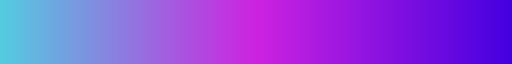

In [2]:
colors_lst, red, cmap = colors.color_scheme()
cmap

# Parameters

In [3]:
## Parameters

## task type
task_type='Regression'


# ## task matrix X
# M_values: np.ndarray = array([0.15, 0.2, 0.015, 0.1, 0.01, 0.03, 0.05, 0.12, 0.23, 0.25, 0.12, 0.1, 0.02, 0.3, 0.35, 0.25,
#                               0.03, 0.02, 0.25, 0.31, 0.02, 0.08, 0.35, 0.1, 0.03, 0.2, 0.1, 0.18, 0.12, 0.35, 0.05, 0.15,
#                               0.25, 0.25, 0.02, 0.01, 0.08, 0.07, 0.35, 0.15, 0.01, 0.25, 0.13, 0.05, 0.03, 0.3, 0.32, 0.05,
#                               0.15, 0.12, 0.25, 0.1, 0.25, 0.3, 0.25, 0.25, 0.04, 0.27, 0.1, 0.11, 0.02, 0.2, 0.4, 0.15,
#                               ])

## specify # of nodes
Nin: int = 0
extraNin: int = 0
Ninter: int = 0
Nout: int = 0
extraNout: int = 0

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
R_vec_i = array([1.])

alpha: float = 0.1  # for network combine attempt
stay_sample: int = 2

# length of training dataset
iterations = int(2e4)  # number of sampled of p

stay_sample = 2

random_state = 42

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = True  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = False  # use 1 or 2 sampled pressures at every time step
include_Power: bool = False
lam: float = 0
    
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [4]:
def network_build_given_Nin_Nout(Nin: int, Nout: int, M_values: NDArray[np.float_]) -> tuple():
    
    # initialize Variables
    Variabs = User_Variables(iterations,\
                             Nin, \
                             extraNin, \
                             Ninter, \
                             Nout, \
                             extraNout, \
                             gamma, \
                             R_update, \
                             use_p_tag, \
                             include_Power, lam, \
                             supress_prints, \
                             bc_noise, \
                             access_interNodes, \
                             task_type, \
                             measure_accuracy_every)
    
    Variabs.assign_alpha_vec(alpha)
    
    # Normalize M
    # M_values_norm = normalize([M_values[:Nin*Nout]], norm="l1")[0]/2  # normalize Nin*Nout values of M to norm of 0.5
    M_mat = M_values[0:Nout*Nin].reshape(Nout, Nin)
    M_line = np.sum(M_mat, axis=1)
    M_values_norm = M_values[:Nin*Nout]/np.max(M_line)*0.75  # normalize so max sum over line will be 0.75
    # M_values_norm = copy.copy(M_values[:Nin*Nout])  # don't normalize
    print('M_norm', M_values_norm)
    Variabs.create_dataset_and_targets(random_state, M_values_norm)
    Variabs.create_noise_for_extras()
    BigClass = Big_Class(Variabs)
        
    # initialize Structure
    inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.extraNin, Variabs.Ninter, 
                                                                            Variabs.Nout, Variabs.extraNout)
        
    
    Strctr = Network_Structure(inInterOutGround_tuple)
    Strctr.build_incidence()
    Strctr.build_edges()
    BigClass.add_Strctr(Strctr)  # add to big class
    
    # initialize State    
    State = Network_State(Variabs)
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
    BigClass.add_State(State)  # add to big class
    
    return Variabs, Strctr, State, BigClass


def random_gen_M(random_state: int, size: NDArray[np.int_]) -> NDArray[np.float_]:
    """
    random_gen_M generates a random M_values array for regression task
    use for multiple_Nin_Nout for example, and before train_loop()
    
    inputs:
    random_state - int, random seed
    size         - size of M_values, train_loop then decides how many to take
    """
    # generate random state
    random_gen = np.random.RandomState(random_state)

    # Generate random values with the defined random state
    M_values = random_gen.rand(size)
    
    return M_values


def train_loop(Variabs, Strctr, State, BigClass):
    loss_mean = [1, 1]
    for l in range(Variabs.iterations):
        
        k = (l//stay_sample)*2 + l%2

        # draw input and desired outputs from dataset
        if not((l+1) % 4):  # add noise only at i=3 etc.
            State.draw_p_in_and_desired(Variabs, k, noise_to_extra=False)  # add noise to extra nodes every 2nd iteration
            State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=False)  # measure and don't change resistances
        else:  # dont add noise to extra nodes
            State.draw_p_in_and_desired(Variabs, k)
            State.solve_flow_given_problem(BigClass, "measure")

        if not l % 2:  # even iterations, take another sampled pressure and measure again
            pass
        else:  # odd iterations, go to dual problem and update resistances
            State.t += 1
            State.calc_loss(BigClass)
            State.update_input_dual(BigClass)
            State.update_output_dual(BigClass)
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
            State.update_Rs(BigClass)
            
        if not (l+1)%window_for_mean:
            # print('l', l)
            loss_mean.append(np.mean(np.mean(np.abs(State.loss_in_t[-window_for_mean:]), axis=1)))
            # print(loss_mean)
            
#         if loss_mean[-1]<10e-8 or (loss_mean[-1]-loss_mean[-2])>0 or loss_mean[-1]>2:
#             break
            
    return State

# Loop

In [5]:
# window_for_mean = 1000
# n = 10
# random_state_M_vec = array([42, 43, 44, 45, 46, 47, 48, 49]) 
# norm_mean_loss = np.zeros([n,n, np.shape(random_state_M_vec)[0]])

# for k, random_state_M in enumerate(random_state_M_vec):
#     M_values = random_gen_M(random_state_M, n*n)
#     for i in range(n):
#         for j in range(n):
#             Nin: int = i + 1
#             Nout: int = j + 1
#             print('Nin', Nin)
#             print('Nout', Nout)

#             Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
#             State = train_loop(Variabs, Strctr, State, BigClass)

#             norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
#             # norm_mean_loss_ij = mean_loss_ij / np.mean(Variabs.targets)
#             print('norm_mean_loss_ij', norm_mean_loss_ij)

#             norm_mean_loss[i, j, k] = norm_mean_loss_ij
#             # plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True)

In [6]:
window_for_mean = 1000
n = 5
random_state_M_vec = array([42, 43, 44, 45, 46, 47, 48, 49]) 
# random_state_M_vec = array([42]) 
norm_mean_loss = np.zeros([n,n, np.shape(random_state_M_vec)[0]])
Nin_vec = np.linspace(1,n,n).astype(np.int32)
Nout_vec = np.linspace(1,n,n).astype(np.int32)
alpha1: float = 0.2  # for network combine attempt

for k, random_state_M in enumerate(random_state_M_vec):
    M_values = random_gen_M(random_state_M, 10*10)
    for i, Nin in enumerate(Nin_vec):
        for j, Nout in enumerate(Nout_vec):
            alpha: float = copy.copy(alpha1)
            print('iteration out of 8: ', k)
            print('Nin', Nin)
            print('Nout', Nout)
            Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
            State = train_loop(Variabs, Strctr, State, BigClass)

            norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
            print('norm_mean_loss_ij', norm_mean_loss_ij)
            
            # if loss too big decrease alpha and calculate again
            if norm_mean_loss_ij > 0.3:
                print('too big loss, decreasing alpha')
                alpha = alpha / 4
                print('new alpha', alpha)
                Variabs, Strctr, State, BigClass = network_build_given_Nin_Nout(Nin, Nout, M_values)
                State = train_loop(Variabs, Strctr, State, BigClass)
                norm_mean_loss_ij = np.mean(np.mean(np.abs(State.loss_norm_in_t[-window_for_mean:]), axis=1))
                print('norm_mean_loss_ij', norm_mean_loss_ij)

            norm_mean_loss[i, j, k] = norm_mean_loss_ij
            # plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True)

iteration out of 8:  0
Nin 1
Nout 1
M_norm [0.75]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 4.8294704773213825e-17
iteration out of 8:  0
Nin 1
Nout 2
M_norm [0.29546741 0.75      ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 2.392969451991563e-16
iteration out of 8:  0
Nin 1
Nout 3
M_norm [0.29546741 0.75       0.57745576]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.0285786032692966e-16
iteration out of 8:  0
Nin 1
Nout 4
M_norm [0.29546741 0.75       0.57745576 0.47227002]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.258939697131918e-16
iteration out of 8:  0
Nin 1
Nout 5
M_norm [0.29546741 0.75       0.57745576 0.47227002 0.12308007]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 2.8716379665886426e-16
iteration out of 8:  0
Nin 2
Nout 1
M_norm [0.21196314 0.53803686]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 5.397887673610567e-17
iteration out of 8:  0
Nin 2
N

norm_mean_loss_ij 3.4104497193369506e-16
iteration out of 8:  1
Nin 1
Nout 5
M_norm [0.14167734 0.75       0.16425664 0.29626027 0.4028366 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.7890343037997436e-16
iteration out of 8:  1
Nin 2
Nout 1
M_norm [0.11916643 0.63083357]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 2.0393355184729554e-16
iteration out of 8:  1
Nin 2
Nout 2
M_norm [0.11916643 0.63083357 0.13815814 0.2491879 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.036533970902776644
iteration out of 8:  1
Nin 2
Nout 3
M_norm [0.07274099 0.38507033 0.08433381 0.15210805 0.20682723 0.54317277]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07564337603629498
iteration out of 8:  1
Nin 2
Nout 4
M_norm [0.07147712 0.37837978 0.08286852 0.14946519 0.20323363 0.5337352
 0.41380547 0.33619453]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 3.1765517562801344
too big loss, decreasing alpha
ne

norm_mean_loss_ij 0.9977165405091084
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.51320143 0.06442117 0.45775188 0.22161021 0.22087868 0.37451632
 0.24206759 0.25146867 0.31345165 0.43654835]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.1297056779124739
iteration out of 8:  2
Nin 3
Nout 1
M_norm [0.37175059 0.04666513 0.33158429]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.8004488796824211e-06
iteration out of 8:  2
Nin 3
Nout 2
M_norm [0.37175059 0.04666513 0.33158429 0.16052903 0.15999913 0.27129048]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07825143220967959
iteration out of 8:  2
Nin 3
Nout 3
M_norm [0.37175059 0.04666513 0.33158429 0.16052903 0.15999913 0.27129048
 0.17534785 0.18215777 0.22705672]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07770340587769677
iteration out of 8:  2
Nin 3
Nout 4
M_norm [0.29433225 0.03694695 0.26253071 0.1270983  0.12667876 0.2147933
 0.13883106 0.14

norm_mean_loss_ij 1.9588608495552187
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.31403384 0.17449305 0.08936597 0.02454121 0.14112926 0.15012737
 0.01540685 0.05185926 0.03681701 0.19921125 0.27185743 0.20642243
 0.31457685 0.14934715 0.19632268 0.08975332]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.12394673532648713
iteration out of 8:  3
Nin 4
Nout 5
M_norm [0.31175635 0.17322757 0.08871786 0.02436323 0.14010574 0.1490386
 0.01529511 0.05148316 0.03655    0.1977665  0.26988583 0.20492538
 0.31229544 0.14826403 0.19489888 0.0891024  0.30765591 0.21216459
 0.13886421 0.09131529]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.10398475911741878
iteration out of 8:  3
Nin 5
Nout 1
M_norm [0.31675228 0.17600356 0.09013957 0.02475365 0.14235095]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.0005470409199484003
iteration out of 8:  3
Nin 5
Nout 2
M_norm [0.31675228 0.17600356 0.09013957 0.02475365 0.14235095 0.15142695

norm_mean_loss_ij 4.697099032200978e-10
iteration out of 8:  4
Nin 5
Nout 2
M_norm [0.21080613 0.17073401 0.06697837 0.20387911 0.08419981 0.25206332
 0.01152836 0.1185681  0.24547016 0.12237007]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.06560791879154747
iteration out of 8:  4
Nin 5
Nout 3
M_norm [0.21080613 0.17073401 0.06697837 0.20387911 0.08419981 0.25206332
 0.01152836 0.1185681  0.24547016 0.12237007 0.13660533 0.02283539
 0.11466374 0.20055527 0.23319537]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.07764354593716935
iteration out of 8:  4
Nin 5
Nout 4
M_norm [0.21080613 0.17073401 0.06697837 0.20387911 0.08419981 0.25206332
 0.01152836 0.1185681  0.24547016 0.12237007 0.13660533 0.02283539
 0.11466374 0.20055527 0.23319537 0.08704762 0.02799007 0.21572125
 0.10618724 0.16883376]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.08997365961806196
iteration out of 8:  4
Nin 5
Nout 5
M_norm [0.21080613 0.17073401 0.0669

norm_mean_loss_ij 1.709543791834936e-07
iteration out of 8:  6
Nin 2
Nout 1
M_norm [0.01442991 0.73557009]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.005179429764773
iteration out of 8:  6
Nin 2
Nout 2
M_norm [0.01442991 0.73557009 0.23501754 0.24666294]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.16472612057694017
iteration out of 8:  6
Nin 2
Nout 3
M_norm [0.0117489  0.59890465 0.19135239 0.20083413 0.5320404  0.2179596 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.9998934568665491
too big loss, decreasing alpha
new alpha 0.05
M_norm [0.0117489  0.59890465 0.19135239 0.20083413 0.5320404  0.2179596 ]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.21926058919829894
iteration out of 8:  6
Nin 2
Nout 4
M_norm [0.00999655 0.50957798 0.16281217 0.17087971 0.45268654 0.18545091
 0.49422452 0.25577548]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 5.887112917825797
too big loss, decreasin

norm_mean_loss_ij 0.01391274280103097
iteration out of 8:  7
Nin 2
Nout 3
M_norm [0.12416445 0.10192664 0.38216437 0.36783563 0.28188938 0.23387121]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.020370650814821093
iteration out of 8:  7
Nin 2
Nout 4
M_norm [0.12416445 0.10192664 0.38216437 0.36783563 0.28188938 0.23387121
 0.22565361 0.08681145]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.04979764679529396
iteration out of 8:  7
Nin 2
Nout 5
M_norm [0.12416445 0.10192664 0.38216437 0.36783563 0.28188938 0.23387121
 0.22565361 0.08681145 0.3175662  0.36974438]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 0.04820582354201209
iteration out of 8:  7
Nin 3
Nout 1
M_norm [0.15309906 0.12567907 0.47122187]
R_vec_i has wrong size, initializing all ones
norm_mean_loss_ij 1.3706414997520824e-16
iteration out of 8:  7
Nin 3
Nout 2
M_norm [0.10539128 0.08651574 0.32438265 0.31222035 0.23926883 0.19851082]
R_vec_i has wrong size, initiali

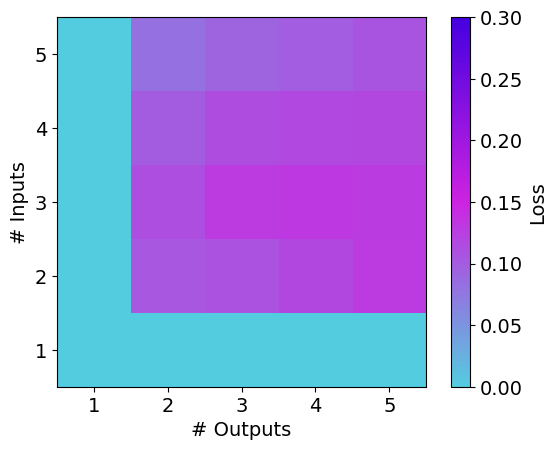

In [7]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.loss_afo_in_out(norm_mean_loss, cmap)

In [8]:
norm_mean_loss[:,:,1]

array([[4.82947048e-17, 3.77181371e-16, 6.12340329e-16, 3.41044972e-16,
        3.78903430e-16],
       [2.03933552e-16, 3.65339709e-02, 7.56433760e-02, 1.19952213e-01,
        1.42935598e-01],
       [4.36091370e-16, 1.64246164e-01, 2.03239954e-01, 1.63229829e-01,
        1.67113625e-01],
       [5.00920992e-12, 7.66260181e-02, 8.58086147e-02, 1.14112681e-01,
        1.31370527e-01],
       [9.76550821e-09, 8.48982816e-02, 8.26752814e-02, 8.51688139e-02,
        1.05633096e-01]])

In [9]:
print(State.output)
print(State.desired)
print(State.loss)
print(np.sum(M_values_norm[:4]))
print(M_values_norm)

[0.8123498  0.85320847 0.92543266 0.55577651 0.899402  ]
[0.7999658  0.79259619 0.90017248 0.56011166 0.98890452]
[[-0.012384   -0.06061228 -0.02526018  0.00433515  0.08950252]]


NameError: name 'M_values_norm' is not defined

In [ ]:
# save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
save_folder_prelim = 'C:/Users/roiee/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'

np.save(save_folder_prelim + 'loss_mat.npy', norm_mean_loss)

In [ ]:
# print(norm_mean_loss)
# print(np.mean(norm_mean_loss, axis=2))
# np.std(norm_mean_loss, axis=2)

# norm_mean_loss with markers and no line
plt.plot(norm_mean_loss[:, 0], marker='o', linestyle='None')  # 'o' for circle markers, 'None' for no line

# Set y-axis to log scale
plt.yscale('log')

plt.legend(['Loss at final step'], loc='lower right')

# Set y-ticks every 1 unit (for log scale, this will display log-spaced ticks)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

# Display the plot
plt.show()